In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/Minor_Project

archive.zip  N_CLAHE.ipynb  ResNet.ipynb  Untitled0.ipynb


In [3]:
!unzip -qq 'drive/MyDrive/Minor_Project/archive.zip' -d 'dataset/'

In [4]:
!ls dataset

auto_test  test  train	val


In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix)
import cv2

In [6]:
np.random.seed(12049)

In [7]:
def get_classes(data_path, classes, data):
    print(f"----{data}----")
    knee_severity={}
    count=0

    for i in range(len(classes)):
        imgs=os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i]=imgs
        count+=len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k}-{classes[k]}: {len(v)} images, {round((len(v)*100)/count, 2)}%"
        )

    return knee_severity

def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data}-{classes[k]}")
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path=os.path.join(data_path, str(k), v[i])
            img=tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1+i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

In [8]:
class_names=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [9]:
base_dir="dataset/"
train_path=os.path.join(base_dir, 'train')
valid_path=os.path.join(base_dir, 'val')
test_path=os.path.join(base_dir, 'test')

In [10]:
train_data=get_classes(train_path, class_names, 'Train')
valid_data=get_classes(valid_path, class_names, 'Valid')
test_data=get_classes(test_path, class_names, 'Test')


----Train----
Grade 0-Healthy: 2286 images, 39.56%
Grade 1-Doubtful: 1046 images, 18.1%
Grade 2-Minimal: 1516 images, 26.24%
Grade 3-Moderate: 757 images, 13.1%
Grade 4-Severe: 173 images, 2.99%
----Valid----
Grade 0-Healthy: 328 images, 39.71%
Grade 1-Doubtful: 153 images, 18.52%
Grade 2-Minimal: 212 images, 25.67%
Grade 3-Moderate: 106 images, 12.83%
Grade 4-Severe: 27 images, 3.27%
----Test----
Grade 0-Healthy: 639 images, 38.59%
Grade 1-Doubtful: 296 images, 17.87%
Grade 2-Minimal: 447 images, 26.99%
Grade 3-Moderate: 223 images, 13.47%
Grade 4-Severe: 51 images, 3.08%


Train data-Healthy


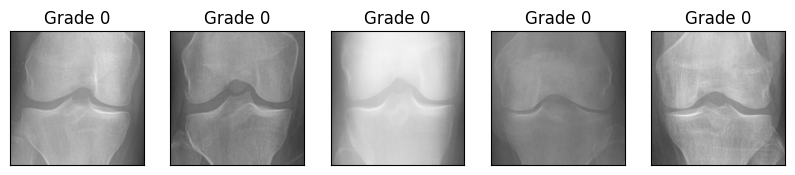

Train data-Doubtful


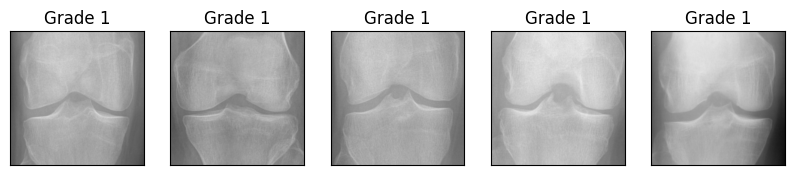

Train data-Minimal


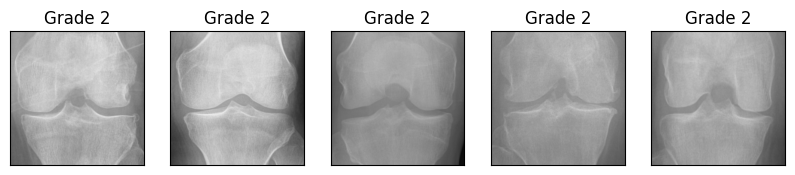

Train data-Moderate


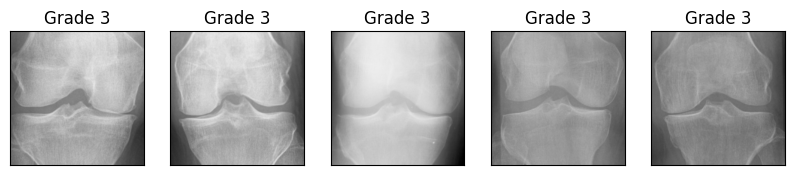

Train data-Severe


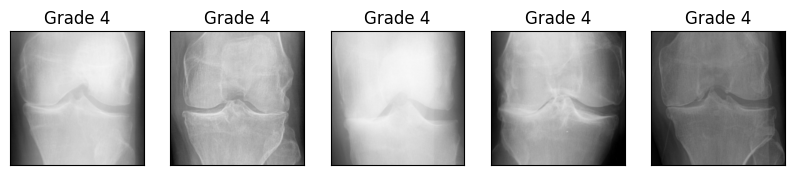

In [11]:
plot_classes(train_data, train_path, class_names, 'Train data')

In [12]:
def get_plot_loss_acc(model, model_name):
    fig=plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

def compute_confusion_matrix(ytrue, ypred, class_names, model_name):
    cm=confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )
    cmn=cm.astype("float")/cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)

def get_evaluate(data, name, model):
    score_model=model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]: .2f}")
    print(f"{name} accuracy: {score_model[1]: .2f}")

def get_predict(data, model):
    predict_model=model.predict(data)
    return predict_model

def get_metrics(y_test, y_pred, model_name):
    acc=accuracy_score(y_test, y_pred)
    bal_acc=balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc: .2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc: .2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

In [13]:
model_name="Inception_ResNet_V2"

target_size=(224, 224)
epochs=20
batch_size=256
img_shape=(224, 224, 3)

save_model_ft=os.path.join('models', f'model_{model_name}_ft.hdf5')

In [14]:
def apply_nclahe(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if gray_image.dtype != np.uint8:
        gray_image = np.uint8(gray_image)
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(gray_image)
    enhanced_rgb = cv2.cvtColor(enhanced_image, cv2.COLOR_GRAY2RGB)

    return enhanced_rgb

Found 5778 images belonging to 5 classes.


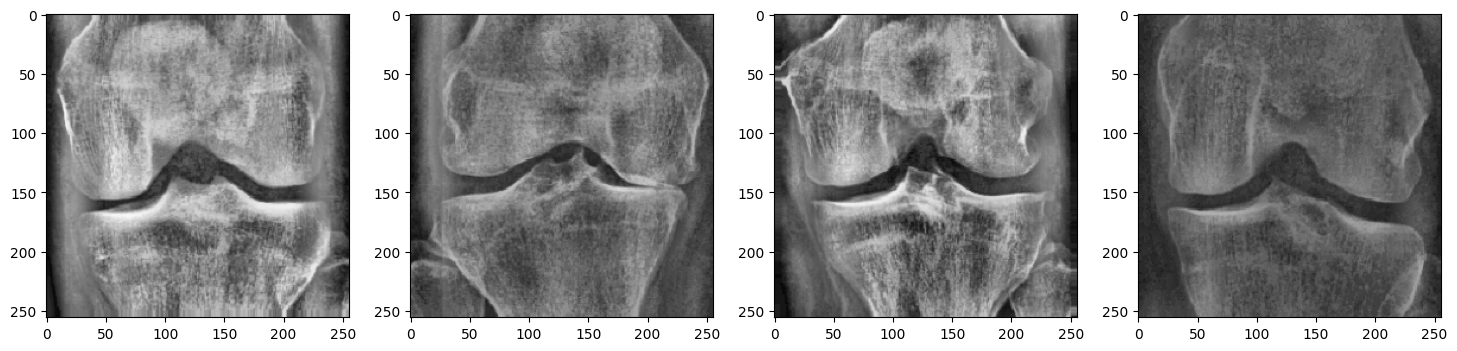

In [15]:
datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: apply_nclahe(x),
    brightness_range=[0.4, 0.6],
    zoom_range=0.05,
    fill_mode='nearest',
)
imagegen=datagen.flow_from_directory(train_path, batch_size=1)
fig, rows=plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype("uint8"))
plt.show()

In [16]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: apply_nclahe(x),  # Apply combined preprocessing
    brightness_range=[0.4, 0.6],
    zoom_range=0.1,
    fill_mode='nearest',
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=lambda x: apply_nclahe(x)  # Apply combined preprocessing
)

In [17]:
train_generator = aug_datagen.flow_from_directory(
    train_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [18]:
y_train=train_generator.labels
y_val=valid_generator.labels

In [19]:
unique, counts=np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights=compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights=dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 2286, 1: 1046, 2: 1516, 3: 757, 4: 173}
{0: 0.5055118110236221, 1: 1.1047801147227534, 2: 0.7622691292875989, 3: 1.5265521796565389, 4: 6.679768786127168}


In [20]:
classes=np.unique(y_train)

early=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=8,
    restore_best_weights=True
)

plateau=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.1, min_delta=0.01,
    min_lr=1e-10, patience=4, mode='auto'
)

In [21]:
model=tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

219055592/219055592 [==============================] - 1s 0us/step


In [22]:
for layer in model.layers:
    layer.trainable=True

model_ft=tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 5)                 7685      
                                                                 
Total params: 54344421 (207.31 MB)
Trainable params: 54283877 (207.08 MB)
Non-trainable params: 60544 (236.50 KB)
_________________________________________________________________


In [23]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft=timeit.default_timer()

history=model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft=timeit.default_timer()

Epoch 1/20
181/181 [==============================] - 250s 732ms/step - loss: 1.1696 - accuracy: 0.4282 - val_loss: 1.5700 - val_accuracy: 0.4552
Epoch 2/20
181/181 [==============================] - 130s 718ms/step - loss: 0.8878 - accuracy: 0.5424 - val_loss: 1.4630 - val_accuracy: 0.4576
Epoch 3/20
181/181 [==============================] - 129s 710ms/step - loss: 0.7986 - accuracy: 0.5890 - val_loss: 0.9265 - val_accuracy: 0.6199
Epoch 4/20
181/181 [==============================] - 132s 729ms/step - loss: 0.7536 - accuracy: 0.6000 - val_loss: 1.1832 - val_accuracy: 0.5521
Epoch 5/20
181/181 [==============================] - 128s 703ms/step - loss: 0.7493 - accuracy: 0.6217 - val_loss: 1.0287 - val_accuracy: 0.6041
Epoch 6/20
181/181 [==============================] - 131s 724ms/step - loss: 0.6811 - accuracy: 0.6445 - val_loss: 1.0209 - val_accuracy: 0.5194
Epoch 7/20
181/181 [==============================] - 132s 729ms/step - loss: 0.6183 - accuracy: 0.6755 - val_loss: 1.4279 -

In [24]:
execution_time_ft=(stop_ft-start_ft)/60
print(
    f"Model {model_name} fine tunibg executed in {execution_time_ft: .2f} minutes"
)

Model Inception_ResNet_V2 fine tunibg executed in  47.52 minutes


In [25]:
model_ft.save(save_model_ft)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


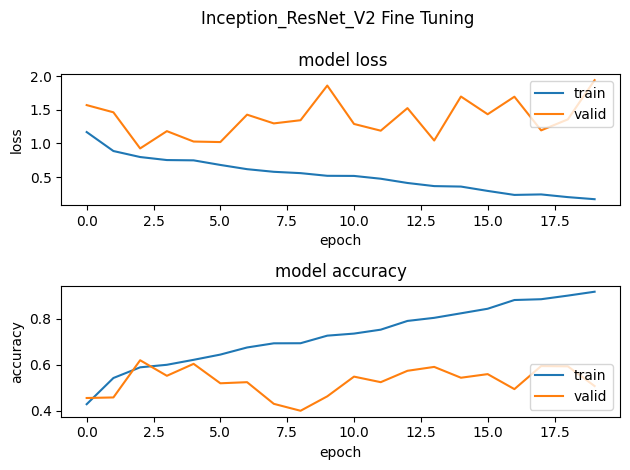

In [26]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [33]:
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")

Training Accuracy: 0.92
Validation Accuracy: 0.51


In [34]:
predict_model_ft=get_predict(valid_generator, model_ft)
get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

26/26 [==============================] - 7s 230ms/step
Accuracy Score - Inception_ResNet_V2:  0.51
Balanced Accuracy Score - Inception_ResNet_V2:  0.56


              precision    recall  f1-score   support

           0       0.76      0.46      0.58       328
           1       0.28      0.36      0.31       153
           2       0.51      0.46      0.48       212
           3       0.44      0.93      0.60       106
           4       0.94      0.59      0.73        27

    accuracy                           0.51       826
   macro avg       0.59      0.56      0.54       826
weighted avg       0.57      0.51      0.51       826



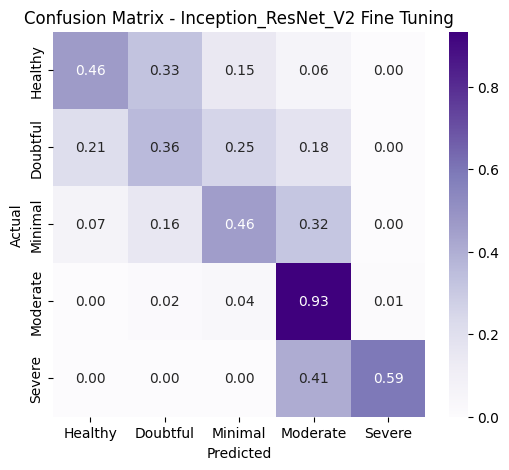

In [35]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)